In [1]:
import numpy as np
import nltk
import pyphen
from nltk import FreqDist
import string
import enchant

In [2]:
## Helper functions for dimensions of the embedding
def words_per_sent(words, sents):
    return len(words) / len(sents)
def words_per_paragraph(words, paragraphs):
    return len(words) / len(paragraphs)
def sents_per_paragraph(sents, paragraphs):
    return len(sents) / len(paragraphs)
def chars_per_paragraph(words, paragraphs):
    n_chars = sum([len(w) for w in words])
    return n_chars / len(paragraphs)
def chars_per_word(words):
    n_chars = sum([len(w) for w in words])
    return n_chars / len(words)
def sylls_per_word(words, sylls=None):
    if not sylls:
        dic = pyphen.Pyphen(lang='en')
        sylls = [len(dic.inserted(w).split('-')) for w in words]
    return sum(sylls) / len(words)
def long_word_ratio(words, length=6):
    long_words = [w for w in words if len(w) > 6]
    return len(long_words) / len(words)
def long_syl_word_ratio(words, sylls=None, length = 2):
    if not sylls:
        dic = pyphen.Pyphen(lang='en')
        sylls = [len(dic.inserted(w).split('-')) for w in words]
    long_syl_words = [w for w, syl in zip(words, sylls) if syl > length]
    return len(long_syl_words) / len(words)
def avg_word_freq(words, freqs):
    n_words = len(words)
    freq_ratios = [freq / n_words for freq in freqs.values()]
    return sum(freq_ratios) / n_words
def dict_hits(words, word_dict):
    return sum([int(word_dict.check(w)) for w in words]) / len(words)

In [3]:
def embed_text(sents, words, paras, dims = 10, long_word = 6, long_syll = 2):
    # helper variables
    words_no_punct = [w for w in words if w not in string.punctuation]
    words_cleaned = [w.lower() for w in words_no_punct]
    dic = pyphen.Pyphen(lang='en')
    word_dict = enchant.Dict('en_US')
    sylls = [len(dic.inserted(w).split('-')) for w in words_cleaned]
    freqs = FreqDist(words_cleaned)
    
    embedding = np.zeros(dims)
    
    embedding[0] = words_per_sent(words_cleaned, sents)
    embedding[1] = words_per_paragraph(words_cleaned, paras)
    embedding[2] = sents_per_paragraph(sents, paras)
    embedding[3] = chars_per_paragraph(words_cleaned, paras)
    embedding[4] = chars_per_word(words_cleaned)
    embedding[5] = sylls_per_word(words_cleaned, sylls)
    embedding[6] = long_word_ratio(words_cleaned, length = long_word)
    embedding[7] = long_syl_word_ratio(words, sylls, length = long_syll)
    embedding[8] = avg_word_freq(words, freqs)
    embedding[9] = dict_hits(words_no_punct, word_dict)
    
    return embedding

In [4]:
def embed_nltk_corpus(corpus):
    sents = corpus.sents
    words = corpus.words
    paras = corpus.paras
    return embed_text(sents, words, paras)

In [5]:
from nltk.corpus import brown

dims = 10
embedding_matrix = np.zeros((len(brown.categories()), dims))

for idx, cat in enumerate(brown.categories()):
    print (idx, cat)
    sents = brown.sents(categories=cat)
    words = brown.words(categories=cat)
    paras = brown.paras(categories=cat)
    embedding = embed_text(sents, words, paras, dims)
    
    embedding_matrix[idx] = embedding

0 adventure
1 belles_lettres
2 editorial
3 fiction
4 government
5 hobbies
6 humor
7 learned
8 lore
9 mystery
10 news
11 religion
12 reviews
13 romance
14 science_fiction


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


scaler = StandardScaler()
standardized_embeddings = scaler.fit_transform(embedding_matrix)

tsne_1 = TSNE(random_state=42)
embeddings_2d_tsne = tsne_1.fit_transform(standardized_embeddings)

pca_1 = PCA(n_components=2)
embeddings_2d_pca = pca_1.fit_transform(standardized_embeddings)

In [9]:
embeddings_2d_tsne

array([[-126.9318  ,  221.61952 ],
       [-251.52641 , -308.1956  ],
       [ 429.06607 , -102.311424],
       [-258.75507 ,  426.41144 ],
       [-392.36096 ,  187.81406 ],
       [ 310.2897  ,  386.2233  ],
       [ -54.060776, -169.66551 ],
       [  84.57324 , -378.37457 ],
       [  47.405888,   41.93587 ],
       [ 304.17285 ,  117.871544],
       [-199.89165 ,    5.454186],
       [ 191.64546 , -143.298   ],
       [-425.49304 ,  -85.702515],
       [ 100.67053 ,  258.4555  ],
       [  10.313268,  484.0468  ]], dtype=float32)

In [13]:
embeddings_2d_pca

array([[-3.48517221, -0.7277068 ],
       [ 2.87072694, -1.85587076],
       [ 0.70485398,  1.31649667],
       [-2.26464985, -1.46309143],
       [ 3.68514934,  1.61462981],
       [ 0.94145638,  0.34736014],
       [-0.99018154, -0.44667228],
       [ 4.59332105, -1.27654229],
       [ 1.50602116, -0.42401502],
       [-3.38481218, -0.70717586],
       [-0.20535939,  2.40386047],
       [ 2.10928309, -1.05045334],
       [ 0.35355282,  1.72522   ],
       [-3.13007099, -0.9427095 ],
       [-3.30411862,  1.48667019]])

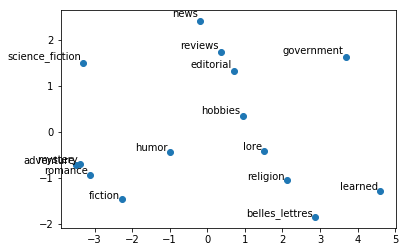

In [24]:
import matplotlib.pyplot as plt

plt.scatter(embeddings_2d_pca[:,0], embeddings_2d_pca[:,1])

for label, x, y in zip(brown.categories(), embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2, y),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

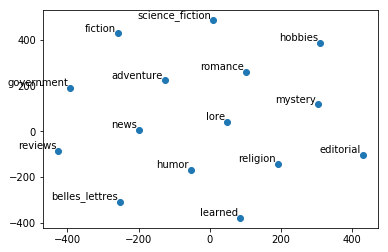

In [26]:
plt.scatter(embeddings_2d_tsne[:,0], embeddings_2d_tsne[:,1])

for label, x, y in zip(brown.categories(), embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2,0),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

In [28]:
from nltk.corpus import gutenberg
gutenberg.paras()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [34]:
dims = 10
embedding_matrix = np.zeros((len(gutenberg.fileids()), dims))

for idx, file in enumerate(gutenberg.fileids()):
    print (idx, file)
    sents = gutenberg.sents(fileids=file)
    words = gutenberg.words(fileids=file)
    paras = gutenberg.paras(fileids=file)
    embedding = embed_text(sents, words, paras, dims)
    
    embedding_matrix[idx] = embedding

0 austen-emma.txt
1 austen-persuasion.txt
2 austen-sense.txt
3 bible-kjv.txt
4 blake-poems.txt
5 bryant-stories.txt
6 burgess-busterbrown.txt
7 carroll-alice.txt
8 chesterton-ball.txt
9 chesterton-brown.txt
10 chesterton-thursday.txt
11 edgeworth-parents.txt
12 melville-moby_dick.txt
13 milton-paradise.txt
14 shakespeare-caesar.txt
15 shakespeare-hamlet.txt
16 shakespeare-macbeth.txt
17 whitman-leaves.txt


In [35]:
scaler = StandardScaler()
standardized_embeddings = scaler.fit_transform(embedding_matrix)

tsne_1 = TSNE(random_state=42)
embeddings_2d_tsne = tsne_1.fit_transform(standardized_embeddings)

pca_1 = PCA(n_components=2)
embeddings_2d_pca = pca_1.fit_transform(standardized_embeddings)

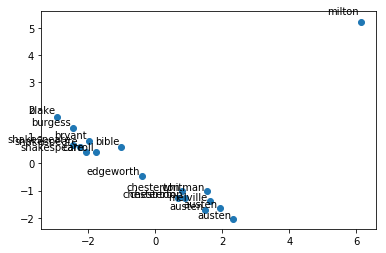

In [37]:
import matplotlib.pyplot as plt

plt.scatter(embeddings_2d_pca[:,0], embeddings_2d_pca[:,1])

for label, x, y in zip([f.split('-')[0] for f in gutenberg.fileids()], embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2, y),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

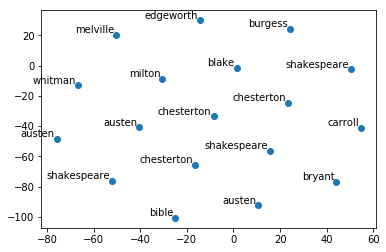

In [38]:
plt.scatter(embeddings_2d_tsne[:,0], embeddings_2d_tsne[:,1])

for label, x, y in zip([f.split('-')[0] for f in gutenberg.fileids()], embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2,0),
        textcoords='offset points', ha='right', va='bottom')
plt.show()